In [1]:
import os

os.chdir("..")

In [2]:
# Use GPU
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import random

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# Other
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from skmultilearn.model_selection import IterativeStratification

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Transformers
import torch
import transformers 
from transformers import LongformerModel, LongformerTokenizerFast

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

## 1. Load and transform data

In [6]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [7]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [8]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_clean'], Y, test_size=0.2)

In [9]:
# Load tokenizer
tokenizer = LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096")

In [22]:
# Check the average and maximum number of tokens in the CSRs
encodings = tokenizer(list(df['CSR_Text_clean']))
average_number_tokens = []
maximum_number_tokens = 0
for encoding in encodings['input_ids']:
    number_tokens = len(encoding)
    average_number_tokens.append(number_tokens)
    if number_tokens > maximum_number_tokens:
        maximum_number_tokens = number_tokens
print('Average number of tokens: ' + str(np.mean(average_number_tokens)))
print('Maximum number of tokens: ' + str(maximum_number_tokens))

Average number of tokens: 36237.42157225719
Maximum number of tokens: 1983786


In [136]:
# Function to split a CSR into encoding chunks of 4096 tokens

def split_doc_into_encoding_chunks(doc):

    # Initialize lists to store encodings
    input_ids_list = []
    attention_mask_list = []
    global_attention_mask_list = []

    # Tokenize document without adding cls and sep token
    encoding = tokenizer(doc, add_special_tokens=False)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Split encoding into chunks of 4096

    start = 0 # Starting position for chunking
    window_size = 4094  # we take 2 off here so that we can fit in our [s] and [SEP] tokens
    total_len = len(input_ids)

    loop = True
    while loop:
        # End position = start + window_size
        end = start + window_size
        # If end position is greater than total length, stop and change endpoint to the final token position
        if end >= total_len:
            loop = False
            end = total_len
        # (1) Extract window from input_ids and attention_mask
        input_ids_chunk = input_ids[start:end]
        attention_mask_chunk = attention_mask[start:end]
        # (2) Add [s] and [SEP] tokens (0 and 2 in Longformer)
        input_ids_chunk = [0] + input_ids_chunk + [2]
        attention_mask_chunk = [1] + attention_mask_chunk + [1]
        # (3) Add padding up to window_size + 2 tokens
        input_ids_chunk += [0] * (window_size - len(input_ids_chunk) + 2)
        attention_mask_chunk += [0] * (window_size - len(attention_mask_chunk) + 2)
        # (4) Add global attention mask
        global_attention_mask_chunk = [0] * len(attention_mask_chunk)
        global_attention_mask_chunk[0] = 1 # global attention on [s] token
        # (5) Format into PyTorch tensors
        input_ids_list.append(input_ids_chunk)
        attention_mask_list.append(attention_mask_chunk)
        global_attention_mask_list.append(global_attention_mask_chunk)
        # Move the window to the next 4096 tokens
        start = end

    # Create dictionary from lists
    encoding_dict = {
        'input_ids': torch.Tensor(input_ids_list).long(),
        'attention_mask': torch.Tensor(attention_mask_list).long(),
        'global_attention_mask': torch.Tensor(global_attention_mask_list).long()
    }

    return encoding_dict

## 2. Compute embeddings with pre-trained Longformer model
- Compute embedding for each chunk
- Take average

In [137]:
# Use GPU
# torch.cuda.empty_cache()
device = torch.device('cuda:4') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=4)

In [138]:
# Load model and tokenizer
model = LongformerModel.from_pretrained('allenai/longformer-base-4096').to(device)
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [192]:
# Compute embeddings for training data

input_data = list(X_train)
outputs_train = np.zeros((len(input_data), 768))
i = 0

for doc in tqdm(input_data):
    
    # Split into encoding chunks of 4096 tokens
    encodings = split_doc_into_encoding_chunks(doc)
    num_chunks = len(encodings['input_ids'])
    
    # Get embedding for each chunk
    chunk_embeddings = []
    for c in range(num_chunks):
        input_ids = encodings['input_ids'][c].to(device)
        attention_mask = encodings['attention_mask'][c].to(device)
        global_attention_mask = encodings['global_attention_mask'][c].to(device)
        
        with torch.no_grad():
            last_hidden_states = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0), global_attention_mask=global_attention_mask.unsqueeze(0))
        chunk_embeddings.append(last_hidden_states[0][:,0,:].cpu().numpy())
        
    # Store average of embeddings
    outputs_train[i:i+1] = np.mean(chunk_embeddings, axis=0)
    i += 1

# Compute embeddings for test data

input_data = list(X_test)
outputs_test = np.zeros((len(input_data), 768))
i = 0

for doc in tqdm(input_data):
    
    # Split into encoding chunks of 4096 tokens
    encodings = split_doc_into_encoding_chunks(doc)
    num_chunks = len(encodings['input_ids'])
    
    # Get embedding for each chunk
    chunk_embeddings = []
    for c in range(num_chunks):
        input_ids = encodings['input_ids'][c].to(device)
        attention_mask = encodings['attention_mask'][c].to(device)
        global_attention_mask = encodings['global_attention_mask'][c].to(device)
        
        with torch.no_grad():
            last_hidden_states = model(input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0), global_attention_mask=global_attention_mask.unsqueeze(0))
        chunk_embeddings.append(last_hidden_states[0][:,0,:].cpu().numpy())
        
    # Store average of embeddings
    outputs_test[i:i+1] = np.mean(chunk_embeddings, axis=0)
    i += 1

  0%|          | 0/6224 [00:00<?, ?it/s]

  0%|          | 0/1879 [00:00<?, ?it/s]

## 3. Classification with balanced weights

### 3.1. Logistic Regression

In [198]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENI

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.7303078878756329


              precision    recall  f1-score   support

           0       0.38      0.66      0.49       205
           1       0.89      0.66      0.76      1483
           2       0.85      0.68      0.75      1435
           3       0.84      0.73      0.78      1311
           4       0.89      0.59      0.71      1411
           5       0.86      0.58      0.69      1309
           6       0.82      0.75      0.79      1227
           7       0.37      0.65      0.48       199
           8       0.92      0.61      0.73      1528
           9       0.79      0.57      0.66      1144
          10       0.60      0.66      0.63       582
          11       0.82      0.64      0.72      1251
          12       0.37      0.65      0.48       199

   micro avg       0.79      0.65      0.71     13284
   macro avg       0.72      0.65      0.67     13284
weighted avg       0.82      0.65      0.72     13284
 samples avg       0.73      0.61      0.62     13284



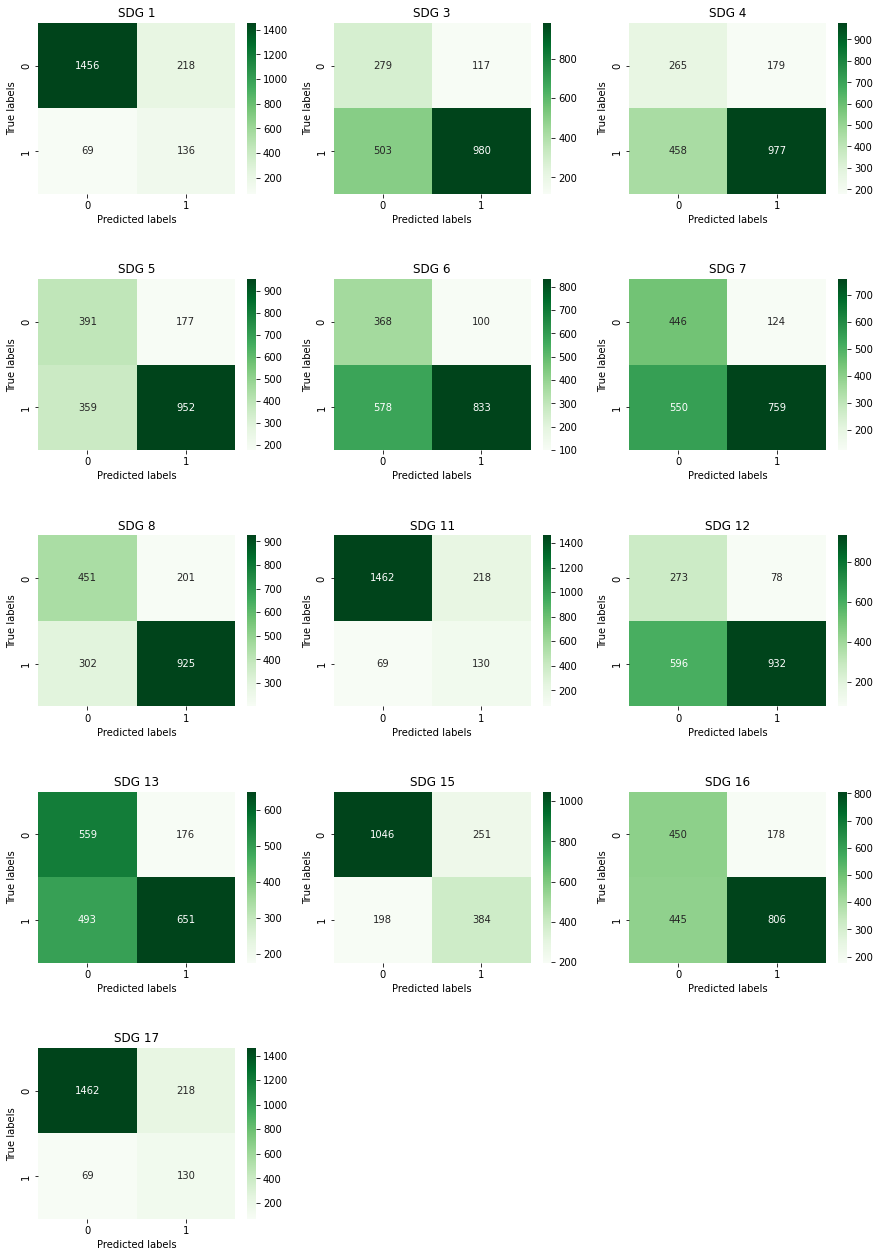

In [199]:
evaluation(grid_lr, outputs_test, Y_test)

### 3.2. Linear SVM

In [200]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_svm.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END .............clf__estimator__C=0.1;, score=0.720 total time=   2.9s
[CV 5/5] END ...............clf__estimator__C=1;, score=0.723 total time=   3.0s
[CV 3/5] END .............clf__estimator__C=0.1;, score=0.726 total time= 1.2min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[CV 1/5] END .............clf__estimator__C=0.1;, score=0.703 total time=   3.5s
[CV 2/5] END ..............clf__estimator__C=10;, score=0.731 total time=   2.8s
[CV 4/5] END .............clf__estimator__C=0.1;, score=0.718 total time= 1.2min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 2/5] END ...............clf__estimator__C=1;, score=0.732 total time=   2.6s
[CV 4/5] END ...............clf__estimator__C=1;, score=0.735 total time=   2.9s
[CV 2/5] END .............clf__estimator__C=0.1;, score=0.721 total time= 1.5min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 5/5] END .............clf__estimator__C=0.1;, score=0.703 total time=   3.7s
[CV 5/5] END ..............clf__estimator__C=10;, score=0.723 total time=   3.5s
[CV 3/5] END ...............clf__estimator__C=1;, score=0.743 total time= 1.1min
[CV 5/5] END ...............clf__estimator__C=1;, score=0.721 total time= 1.2min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 3/5] END .............clf__estimator__C=0.1;, score=0.722 total time=   4.7s
[CV 1/5] END .............clf__estimator__C=0.1;, score=0.707 total time= 1.5min
[CV 5/5] END ..............clf__estimator__C=10;, score=0.718 total time= 1.4min
Best Parameters: {'clf__estimator__C': 1}
Mean cross-validated F1-score of the best estimator: 0.7286494277853873


              precision    recall  f1-score   support

           0       0.37      0.65      0.47       205
           1       0.88      0.64      0.74      1483
           2       0.84      0.68      0.75      1435
           3       0.85      0.70      0.77      1311
           4       0.89      0.60      0.71      1411
           5       0.86      0.56      0.68      1309
           6       0.82      0.75      0.79      1227
           7       0.35      0.64      0.45       199
           8       0.91      0.61      0.73      1528
           9       0.77      0.57      0.66      1144
          10       0.59      0.68      0.63       582
          11       0.83      0.63      0.71      1251
          12       0.35      0.64      0.45       199

   micro avg       0.79      0.64      0.71     13284
   macro avg       0.72      0.64      0.66     13284
weighted avg       0.82      0.64      0.71     13284
 samples avg       0.73      0.61      0.62     13284



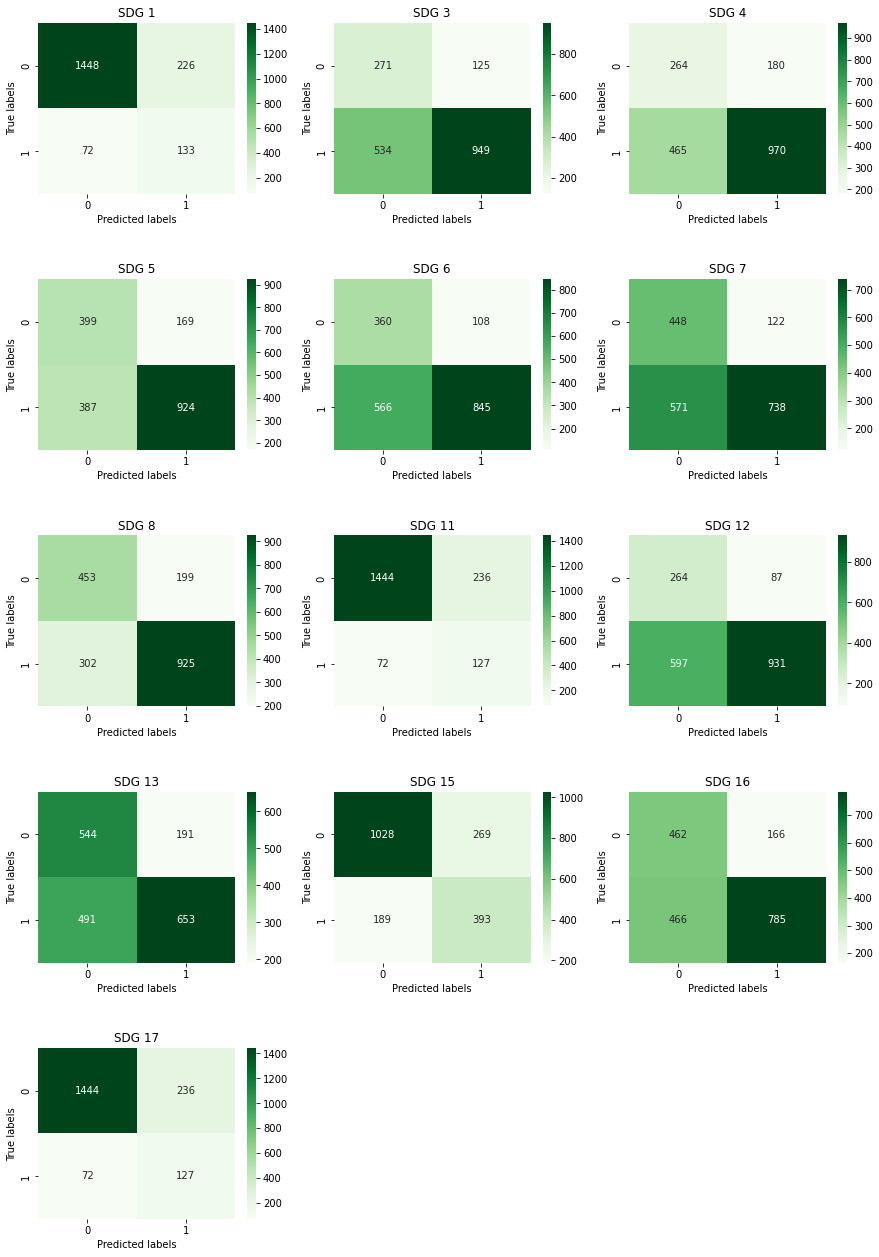

In [201]:
evaluation(grid_svm, outputs_test, Y_test)

### 3.3. Random Forest

In [202]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__n_estimators': [50, 100], # Number of trees in the forest
    'clf__estimator__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_rf.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENI

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Best Parameters: {'clf__estimator__max_depth': 10, 'clf__estimator__n_estimators': 50}
Mean cross-validated F1-score of the best estimator: 0.7466953579519717


              precision    recall  f1-score   support

           0       0.51      0.20      0.28       205
           1       0.80      0.98      0.88      1483
           2       0.78      0.98      0.87      1435
           3       0.73      0.97      0.83      1311
           4       0.82      0.82      0.82      1411
           5       0.76      0.84      0.80      1309
           6       0.72      0.92      0.81      1227
           7       0.49      0.21      0.30       199
           8       0.84      0.89      0.87      1528
           9       0.71      0.77      0.74      1144
          10       0.65      0.49      0.56       582
          11       0.70      0.90      0.79      1251
          12       0.51      0.21      0.30       199

   micro avg       0.76      0.85      0.80     13284
   macro avg       0.69      0.71      0.68     13284
weighted avg       0.75      0.85      0.79     13284
 samples avg       0.76      0.85      0.77     13284



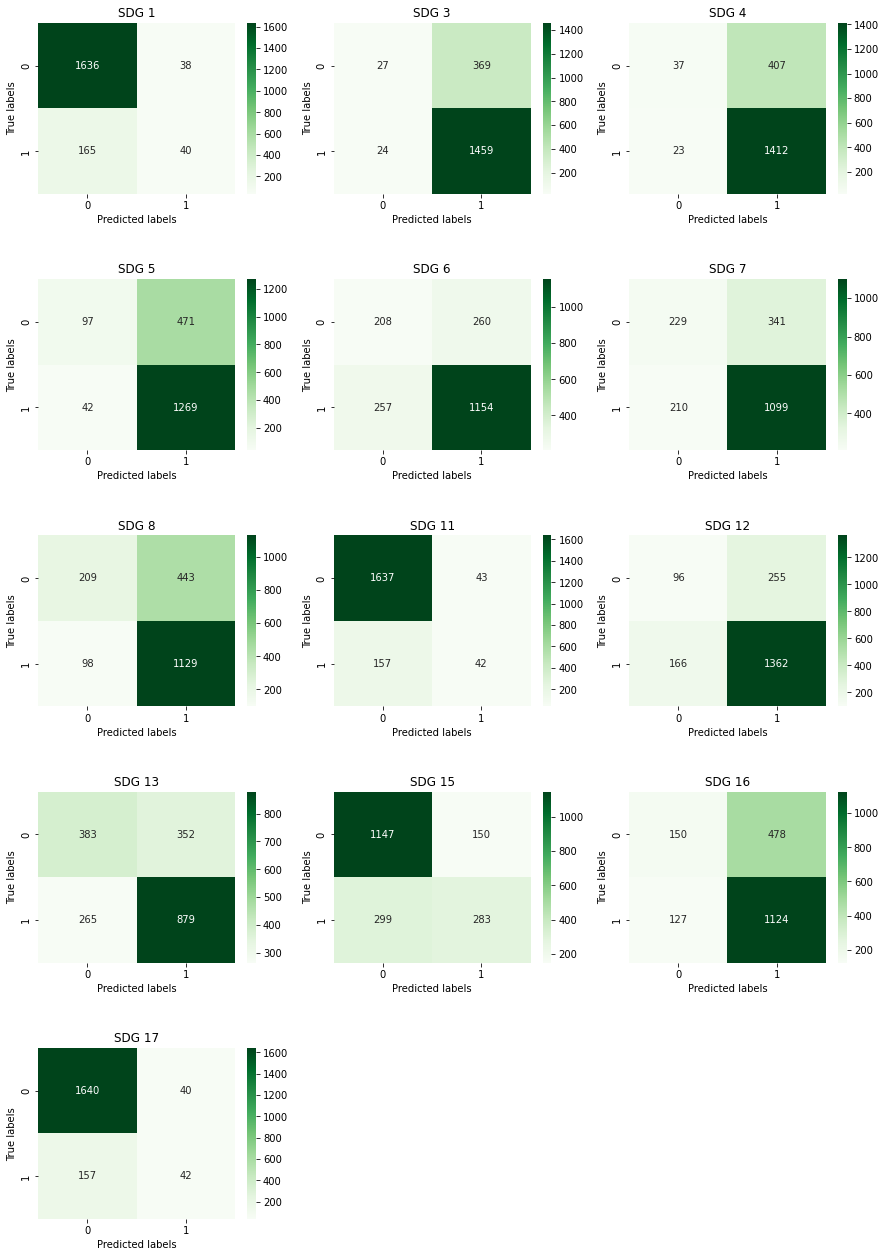

[CV 1/5] END ...............clf__estimator__C=1;, score=0.724 total time=   3.6s
[CV 4/5] END ..............clf__estimator__C=10;, score=0.734 total time=   2.9s
[CV 5/5] END .............clf__estimator__C=0.1;, score=0.706 total time= 1.4min
[CV 4/5] END ..............clf__estimator__C=10;, score=0.722 total time= 1.2min
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50;, score=0.748 total time=  43.4s
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=0.750 total time= 1.4min
[CV 5/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100;, score=0.706 total time= 1.8min


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 4/5] END .............clf__estimator__C=0.1;, score=0.712 total time=   3.3s
[CV 1/5] END ..............clf__estimator__C=10;, score=0.721 total time=   3.6s
[CV 1/5] END ...............clf__estimator__C=1;, score=0.716 total time= 1.3min
[CV 3/5] END ..............clf__estimator__C=10;, score=0.737 total time= 1.4min
[CV 5/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50;, score=0.744 total time=  43.8s
[CV 5/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=0.747 total time= 1.5min
[CV 1/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50;, score=0.672 total time=  55.4s
[CV 4/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50;, score=0.684 total time=  55.0s
[CV 2/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=0.750 total time= 1.5min
[CV 1/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100;, score=0.698 total time= 1.8min
[CV 5/5] END clf__est

In [203]:
evaluation(grid_rf, outputs_test, Y_test)